#Unsupervised Deep Learning (SOM)

In [14]:
!pip install MiniSom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Importing the necessary libraries

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from pylab import bone, pcolor, colorbar, plot, show,figure
import seaborn as sns

## Part 1 - Data Preprocessing

In [67]:
df = pd.read_csv('Credit_Card_Applications.csv')
df_f = df.copy()

In [68]:
df.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


Last column represents the clients appliance status. 1 is for Applied 0 is for not applied

Last column need to be dropped

In [69]:
y = df.iloc[:, -1].values
df = pd.DataFrame(df.drop(["Class"], axis=1))

In [70]:
df.shape

(690, 15)

In [71]:
df.isna().any()

CustomerID    False
A1            False
A2            False
A3            False
A4            False
A5            False
A6            False
A7            False
A8            False
A9            False
A10           False
A11           False
A12           False
A13           False
A14           False
dtype: bool

###cols

In [75]:
def col_types(dataframe, cat_th=10, car_th=30):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Dataframe for isnpection
        cat_th: int, optional
                categorical columns that seem like numerical
        car_th: int, optinal
                cardinal columns that seem like categorical

    Returns
    ------
        cat_cols: list
                categorical column names list
        num_cols: list
                numerical column names list
        cat_but_car: list
                cardinal column names list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı


    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [76]:
cat_cols, num_cols, cat_but_car = col_types(df)

Observations: 690
Variables: 15
cat_cols: 7
num_cols: 8
cat_but_car: 0
num_but_cat: 7


### Correlations

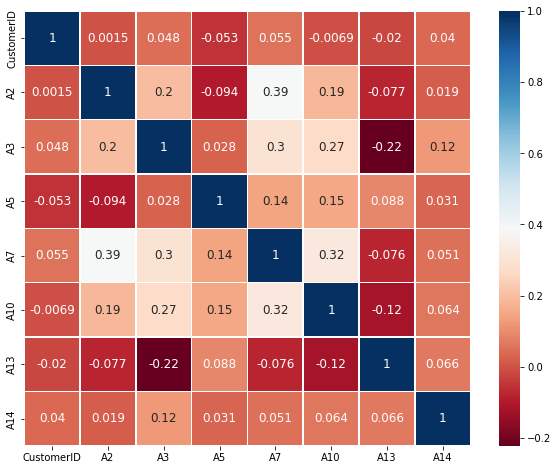

In [77]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)
correlation_matrix(df,num_cols)   

Missing Column check

In [78]:
def missing_col(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print("Missing columns")
    print(missing_df, end="\n")

    if na_name:
        return na_columns
missing_col(df)

Missing columns
Empty DataFrame
Columns: [n_miss, ratio]
Index: []


Using MinMaxScaler instead of normalizing because the distribution of the quantity is normal

In [79]:
sc = MinMaxScaler(feature_range = (0,1))
df = sc.fit_transform(df)

##Training SOM 

In [90]:
som = MiniSom(x=10, y=10, input_len= 15)
som.random_weights_init(df)
som.train_random(data = df, num_iteration = 100)

Creating  Self Organizing Map by using MiniSom

## Visualizing the map to determine potential frauds

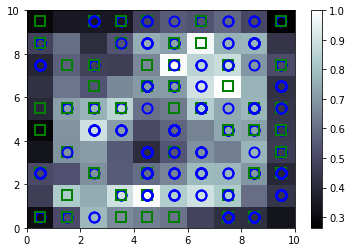

In [91]:
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['b', 'g']
for i, x in enumerate(df):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

Potential cheaters have high MID value (White)

## Finding the frauds

In [94]:
mappings = som.win_map(df)

In [95]:
frauds = np.concatenate((mappings[(5,7)], mappings[(7,6)],mappings[(4,1)]), axis = 0)
frauds = sc.inverse_transform(frauds)

#Supervised Deep Learning (ANN)

##Create Matrix of Features

In [96]:
df = pd.DataFrame(df)

In [97]:
all_customers = df.iloc[:, 1:].values

## Create Dependent Variable

In [98]:
is_fraud = np.zeros(len(df))
for i in range(len(df)):
  if df.iloc[i,0] in frauds:
    is_fraud[i] = 1

## Feature Scaling

In [99]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
all_customers = sc.fit_transform(all_customers)

##Tensorflow

In [100]:
import tensorflow as tf
tf.__version__

'2.8.2'

## Building the ANN model

In [101]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=2, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [102]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [103]:
ann.fit(all_customers, is_fraud, batch_size = 1, epochs = 10)

Epoch 1/10
690/690 [==============================] - 1s 1ms/step - loss: 0.5761 - accuracy: 0.8087
Epoch 2/10
690/690 [==============================] - 1s 1ms/step - loss: 0.2532 - accuracy: 0.9710
Epoch 3/10
690/690 [==============================] - 1s 1ms/step - loss: 0.1480 - accuracy: 0.9913
Epoch 4/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0964 - accuracy: 0.9971
Epoch 5/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0655 - accuracy: 0.9971
Epoch 6/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0459 - accuracy: 0.9971
Epoch 7/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0356 - accuracy: 0.9971
Epoch 8/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0310 - accuracy: 0.9971
Epoch 9/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0283 - accuracy: 0.9971
Epoch 10/10
690/690 [==============================] - 1s 1ms/step - loss: 0.0264 - accuracy: 0.9971

## Predicting test set results

In [105]:
y_pred = ann.predict(all_customers)
y_pred = np.concatenate((df_f.iloc[:, 0:1].values, y_pred), axis = 1)
y_pred = y_pred[y_pred[:, 1].argsort()]
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ["Customer ID","Probability"]
print(y_pred)

     Customer ID   Probability
0     15673907.0  2.356598e-07
1     15571415.0  4.089683e-07
2     15644400.0  4.328180e-07
3     15757434.0  4.737853e-07
4     15699340.0  5.369434e-07
..           ...           ...
685   15623072.0  9.387258e-02
686   15680895.0  9.387258e-02
687   15592412.0  9.387258e-02
688   15651460.0  9.742066e-02
689   15799785.0  1.051925e-01

[690 rows x 2 columns]
